In [1]:
import os
import pandas as pd
import numpy as np
import scipy.stats as st
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## Input data

In [2]:
celltype = "TRB_HUMAN"
myfiles = [x for x in os.listdir(".") if x.startswith('cdr3-clones') and celltype in x]
myfiles

['cdr3-clones-Behcet-TRB_HUMAN-after-reassignment.csv',
 'cdr3-clones-Paired_rerun-TRB_HUMAN-after-reassignment.csv',
 'cdr3-clones-CEA-CEF-TRB_HUMAN-after-reassignment.csv']

In [3]:
pt_file="20180604_Run029_pt-table.csv"
run = "run29"
plotfile=run + "-similarity-" + celltype + '.pdf'
suspects_list = run + "-similarity-" + celltype + ".txt"

## Import clonesdata

In [4]:
clones = pd.read_csv(myfiles[0], sep="\t")
if len(myfiles) > 1:
    for clones_file in myfiles[1:]:
        clones = pd.concat([clones, pd.read_csv(clones_file, sep="\t")])

In [5]:
clones.head()

,Sample,MID,cdr3pep,freq,uniq_umis,V_sub,J_sub,sum_sites,avg_sites,read_perc,umi_perc
0,B001-T_S17,ACGTACGT,CSVLVAGGLGEQFFG,4977,1448,TRBV29-1,"TRBJ2-1,TRBJ2-7,TRBJ2-5",9914,1.991963,6.831471,4.429083
1,B001-T_S17,ACGTACGT,CSVGKGPTNYGYTFG,1334,384,TRBV29-1,"TRBJ1-2,TRBJ2-1,TRBJ2-7",2653,1.988756,1.831059,1.174563
2,B001-T_S17,ACGTACGT,CSVPTRDTEAFFG,821,220,TRBV29-1,TRBJ1-1,1632,1.987820,1.126911,0.672927
3,B001-T_S17,ACGTACGT,CSVARRVYNEQFFG,612,203,TRBV29-1,TRBJ2-1,1215,1.985294,0.840036,0.620928
4,B001-T_S17,ACGTACGT,CSVGGGNSPLHFG,534,146,TRBV29-1,"TRBJ1-6,TRBJ2-7",1592,2.981273,0.732973,0.446579


In [6]:
# Summarize data on CDR3
clones = clones.groupby(by=['Sample','cdr3pep']).sum()
clones = clones.reset_index()
clones = clones.sort_values(['Sample','freq'], ascending=False)
clones.head()

,Sample,cdr3pep,freq,uniq_umis,sum_sites,avg_sites,read_perc,umi_perc
1160544,PS-53-TR_S233,CSATDREPYEQYFG,787,42,1566,1.989835,2.510447,1.461378
1160638,PS-53-TR_S233,CSVELVQRNEQFFG,531,30,1054,1.984934,1.693834,1.043841
1160713,PS-53-TR_S233,CSVYGIRDRDNYGYTFG,436,27,870,1.995413,1.390794,0.939457
1160603,PS-53-TR_S233,CSVDEGAPNGYTFG,326,15,646,1.981595,1.039906,0.521921
1160607,PS-53-TR_S233,CSVEAGYAEAFFG,306,12,609,1.990196,0.976108,0.417537


## Import patient table

In [7]:
pt = pd.read_csv(pt_file, sep="\t")
pt = pt.rename(columns = {'Sample': 'SampleInfo'})
pt.head()

,Samples order,Sample_ID,Sample name,MID,Project,Species,Chain,Patient,SampleInfo,UMI
0,S1,N701_S502,BMC110-1-BuH,NaN,BMC,human,BCRh,BMC110,V1,yes
1,S2,N702_S502,BMC110-2-BuH,NaN,BMC,human,BCRh,BMC110,V2,yes
2,S3,N703_S502,BMC111-1-BuH,NaN,BMC,human,BCRh,BMC111,V1,yes
3,S4,N704_S502,BMC111-2-BuH,NaN,BMC,human,BCRh,BMC111,V2,yes
4,S5,N705_S502,BMC116-1-BuH,NaN,BMC,human,BCRh,BMC116,V1,yes


In [8]:
# Concatenate sample-id and nr in a new column
f = lambda x,y: str(x) + "_" + str(y)
pt['Sample'] = [name for name in map(f, pt['Sample name'], pt['Samples order'])]
pt = pt[["Sample","Patient"]]

In [9]:
pt.head()

,Sample,Patient
0,BMC110-1-BuH_S1,BMC110
1,BMC110-2-BuH_S2,BMC110
2,BMC111-1-BuH_S3,BMC111
3,BMC111-2-BuH_S4,BMC111
4,BMC116-1-BuH_S5,BMC116


## Merge clones with pt

In [10]:
# Join data frames
df = pd.merge(clones, pt, how='inner', on = 'Sample')
df.head()

,Sample,cdr3pep,freq,uniq_umis,sum_sites,avg_sites,read_perc,umi_perc,Patient
0,PS-53-TR_S233,CSATDREPYEQYFG,787,42,1566,1.989835,2.510447,1.461378,BP0439
1,PS-53-TR_S233,CSVELVQRNEQFFG,531,30,1054,1.984934,1.693834,1.043841,BP0439
2,PS-53-TR_S233,CSVYGIRDRDNYGYTFG,436,27,870,1.995413,1.390794,0.939457,BP0439
3,PS-53-TR_S233,CSVDEGAPNGYTFG,326,15,646,1.981595,1.039906,0.521921,BP0439
4,PS-53-TR_S233,CSVEAGYAEAFFG,306,12,609,1.990196,0.976108,0.417537,BP0439


## Determine distance between samples

In [11]:
df_pivot = df.pivot_table(columns=['Patient','Sample'], index='cdr3pep', values='freq')
df_pivot = df_pivot.fillna(0)
df_pivot.head()

Patient                    A25                                               \
Sample          CEA-E01-Tu_S61 CEA-E02-Tu_S62 CEA-E03-Tu_S63 CEA-E04-Tu_S77   
cdr3pep                                                                       
CAAAAGGTGEKLFFG            0.0            0.0            0.0            0.0   
CAAAAGKSGEKLFFG            0.0            0.0            0.0            0.0   
CAAAAVAYNEQFFG             0.0            0.0            0.0            0.0   
CAAAAVGNTEAFFG             0.0            0.0            0.0            0.0   
CAAADGDNEQFFG              0.0            0.0            0.0            0.0   

Patient                                                                      \
Sample          CEA-E06-Tu_S78 CEA-E07-Tu_S79 CEA-E08-Tu_S80 CEA-E10-Tu_S81   
cdr3pep                                                                       
CAAAAGGTGEKLFFG            0.0            0.0            0.0            0.0   
CAAAAGKSGEKLFFG            0.0            0.0            0.0            0.0   
CAAAAVAYNEQFFG             0.0            0.0            0.0            0.0   
CAAAAVGNTEAFFG             0.0            0.0            0.0            0.0   
CAAADGDNEQFFG              0.0            0.0            0.0            0.0   

Patient                                             ...                  P452  \
Sample          CEA-E11-Tu_S82 CEA-E12-Tu_S99       ...       CEA-F30-Tu_S197   
cdr3pep                                             ...                         
CAAAAGGTGEKLFFG            0.0            0.0       ...                   0.0   
CAAAAGKSGEKLFFG            0.0            0.0       ...                   0.0   
CAAAAVAYNEQFFG             0.0            0.0       ...                   0.0   
CAAAAVGNTEAFFG             0.0            0.0       ...                   0.0   
CAAADGDNEQFFG              0.0            0.0       ...                   0.0   

Patient                                                          \
Sample          CEA-F31-Tu_S210 CEA-F32-Tu_S211 CEA-F33-Tu_S212   
cdr3pep                                                           
CAAAAGGTGEKLFFG             0.0             0.0             0.0   
CAAAAGKSGEKLFFG             0.0             0.0             0.0   
CAAAAVAYNEQFFG              0.0             0.0             0.0   
CAAAAVGNTEAFFG              0.0             0.0             0.0   
CAAADGDNEQFFG               0.0             0.0             0.0   

Patient                                                          \
Sample          CEA-F34-Tu_S213 CEA-F35-Tu_S214 CEA-F36-Tu_S215   
cdr3pep                                                           
CAAAAGGTGEKLFFG             0.0             0.0             0.0   
CAAAAGKSGEKLFFG             0.0             0.0             0.0   
CAAAAVAYNEQFFG              0.0             0.0             0.0   
CAAAAVGNTEAFFG              0.0             0.0             0.0   
CAAADGDNEQFFG               0.0             0.0             0.0   

Patient                                                          
Sample          CEA-F37-Tu_S216 CEA-F38-Tu_S217 CEA-F39-Tu_S232  
cdr3pep                                                          
CAAAAGGTGEKLFFG             0.0             0.0             0.0  
CAAAAGKSGEKLFFG             0.0             0.0             0.0  
CAAAAVAYNEQFFG              0.0             0.0             0.0  
CAAAAVGNTEAFFG              0.0             0.0             0.0  
CAAADGDNEQFFG               0.0             0.0             0.0  

[5 rows x 109 columns]

In [12]:
sim = 1 - pairwise_distances(df_pivot.T, metric = "braycurtis")
sim = pd.DataFrame(sim, index=df_pivot.columns, columns=df_pivot.columns)
sim.head()

Patient                           A25                                \
Sample                 CEA-E01-Tu_S61 CEA-E02-Tu_S62 CEA-E03-Tu_S63   
Patient Sample                                                        
A25     CEA-E01-Tu_S61       1.000000       0.072064       0.100018   
        CEA-E02-Tu_S62       0.072064       1.000000       0.133206   
        CEA-E03-Tu_S63       0.100018       0.133206       1.000000   
        CEA-E04-Tu_S77       0.049010       0.136668       0.104014   
        CEA-E06-Tu_S78       0.056016       0.137854       0.115730   

Patient                                                              \
Sample                 CEA-E04-Tu_S77 CEA-E06-Tu_S78 CEA-E07-Tu_S79   
Patient Sample                                                        
A25     CEA-E01-Tu_S61       0.049010       0.056016       0.038733   
        CEA-E02-Tu_S62       0.136668       0.137854       0.032156   
        CEA-E03-Tu_S63       0.104014       0.115730       0.035185   
        CEA-E04-Tu_S77       1.000000       0.173108       0.021676   
        CEA-E06-Tu_S78       0.173108       1.000000       0.026418   

Patient                                                              \
Sample                 CEA-E08-Tu_S80 CEA-E10-Tu_S81 CEA-E11-Tu_S82   
Patient Sample                                                        
A25     CEA-E01-Tu_S61       0.023346       0.050931       0.052722   
        CEA-E02-Tu_S62       0.015248       0.081566       0.107038   
        CEA-E03-Tu_S63       0.019262       0.088359       0.095016   
        CEA-E04-Tu_S77       0.010422       0.089829       0.107313   
        CEA-E06-Tu_S78       0.014615       0.099765       0.123040   

Patient                                     ...                  P452  \
Sample                 CEA-E12-Tu_S99       ...       CEA-F30-Tu_S197   
Patient Sample                              ...                         
A25     CEA-E01-Tu_S61       0.045776       ...              0.002493   
        CEA-E02-Tu_S62       0.101939       ...              0.002936   
        CEA-E03-Tu_S63       0.086721       ...              0.001251   
        CEA-E04-Tu_S77       0.117408       ...              0.003185   
        CEA-E06-Tu_S78       0.127394       ...              0.003803   

Patient                                                                 \
Sample                 CEA-F31-Tu_S210 CEA-F32-Tu_S211 CEA-F33-Tu_S212   
Patient Sample                                                           
A25     CEA-E01-Tu_S61        0.001772        0.002063        0.002109   
        CEA-E02-Tu_S62        0.001612        0.001766        0.001856   
        CEA-E03-Tu_S63        0.001439        0.001366        0.001308   
        CEA-E04-Tu_S77        0.003698        0.003839        0.003624   
        CEA-E06-Tu_S78        0.004771        0.004857        0.006159   

Patient                                                                 \
Sample                 CEA-F34-Tu_S213 CEA-F35-Tu_S214 CEA-F36-Tu_S215   
Patient Sample                                                           
A25     CEA-E01-Tu_S61        0.002266        0.001684        0.002347   
        CEA-E02-Tu_S62        0.002409        0.001976        0.002667   
        CEA-E03-Tu_S63        0.001907        0.001243        0.001698   
        CEA-E04-Tu_S77        0.002442        0.003061        0.003017   
        CEA-E06-Tu_S78        0.003810        0.004954        0.004660   

Patient                                                                 
Sample                 CEA-F37-Tu_S216 CEA-F38-Tu_S217 CEA-F39-Tu_S232  
Patient Sample                                                          
A25     CEA-E01-Tu_S61        0.001819        0.001849        0.001754  
        CEA-E02-Tu_S62        0.001607        0.001906        0.001289  
        CEA-E03-Tu_S63        0.001683        0.001414        0.001613  
        CEA-E04-Tu_S77        0.002937        0.002377        0.002107  
        CEA

## Create a heatmap

In [13]:
def drawBox(end, length):
    '''
    Description: draw a square with lines
    In: start (int), length (int)
    Out: None, 4 lines will be drawn on the canvas
    '''
    linewidth = 5
    low = end - length
    high = end
    plt.plot([low, high], [high, high], 'k-', lw=linewidth)   # N
    plt.plot([high, high], [low, high], 'k-', lw=linewidth)   # E
    plt.plot([low, high], [low, low], 'k-', lw=linewidth)     # S
    plt.plot([low, low], [low, high], 'k-', lw=linewidth)     # W

In [14]:
def drawHeatmap(overlap):
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 22}

    matplotlib.rc('font', **font)

    fig, ax = plt.subplots(figsize=(60, 60))
    fig.subplots_adjust(bottom=0.3)

    # is used for log scaling
    Z1 = overlap.values
    Z1[Z1 <= 0] = Z1[Z1 > 0].min()  # Replace any value below or equal to zero with lowest value above zero
    
    print("min value:", Z1.min())
    print("max value:", Z1.max())

    # get the patient-id
    labels_x = [x[0] for x in overlap.index]
    labels_y = [y[0] for y in overlap.columns]

    # draw heatmap
    plt.pcolor(overlap.values, cmap=plt.cm.viridis, norm=colors.LogNorm(vmin=Z1.min(), vmax=Z1.max()))
    #plt.pcolor(overlap.values, cmap=plt.cm.viridis)
    plt.colorbar()
    plt.yticks(np.arange(0.5, len(overlap.index), 1), overlap.columns, rotation=0)
    plt.xticks(np.arange(0.5, len(overlap.columns), 1), overlap.index, rotation=90)

    # Add lines around same patient-id
    prev_label = None
    length = 0
    for i in range(len(labels_x)):
        if prev_label is not None and prev_label != labels_x[i]:
            drawBox(i, length)
            length = 0
        prev_label = labels_x[i]
        length +=1
    i += 1
    drawBox(i, length)

    # Save figure to file
    fig.savefig(plotfile)
    print("Wrote", plotfile, "to disk")

min value: 3.2007169605940966e-05
max value: 1.0
Wrote run29-similarity-TRB_HUMAN.pdf to disk


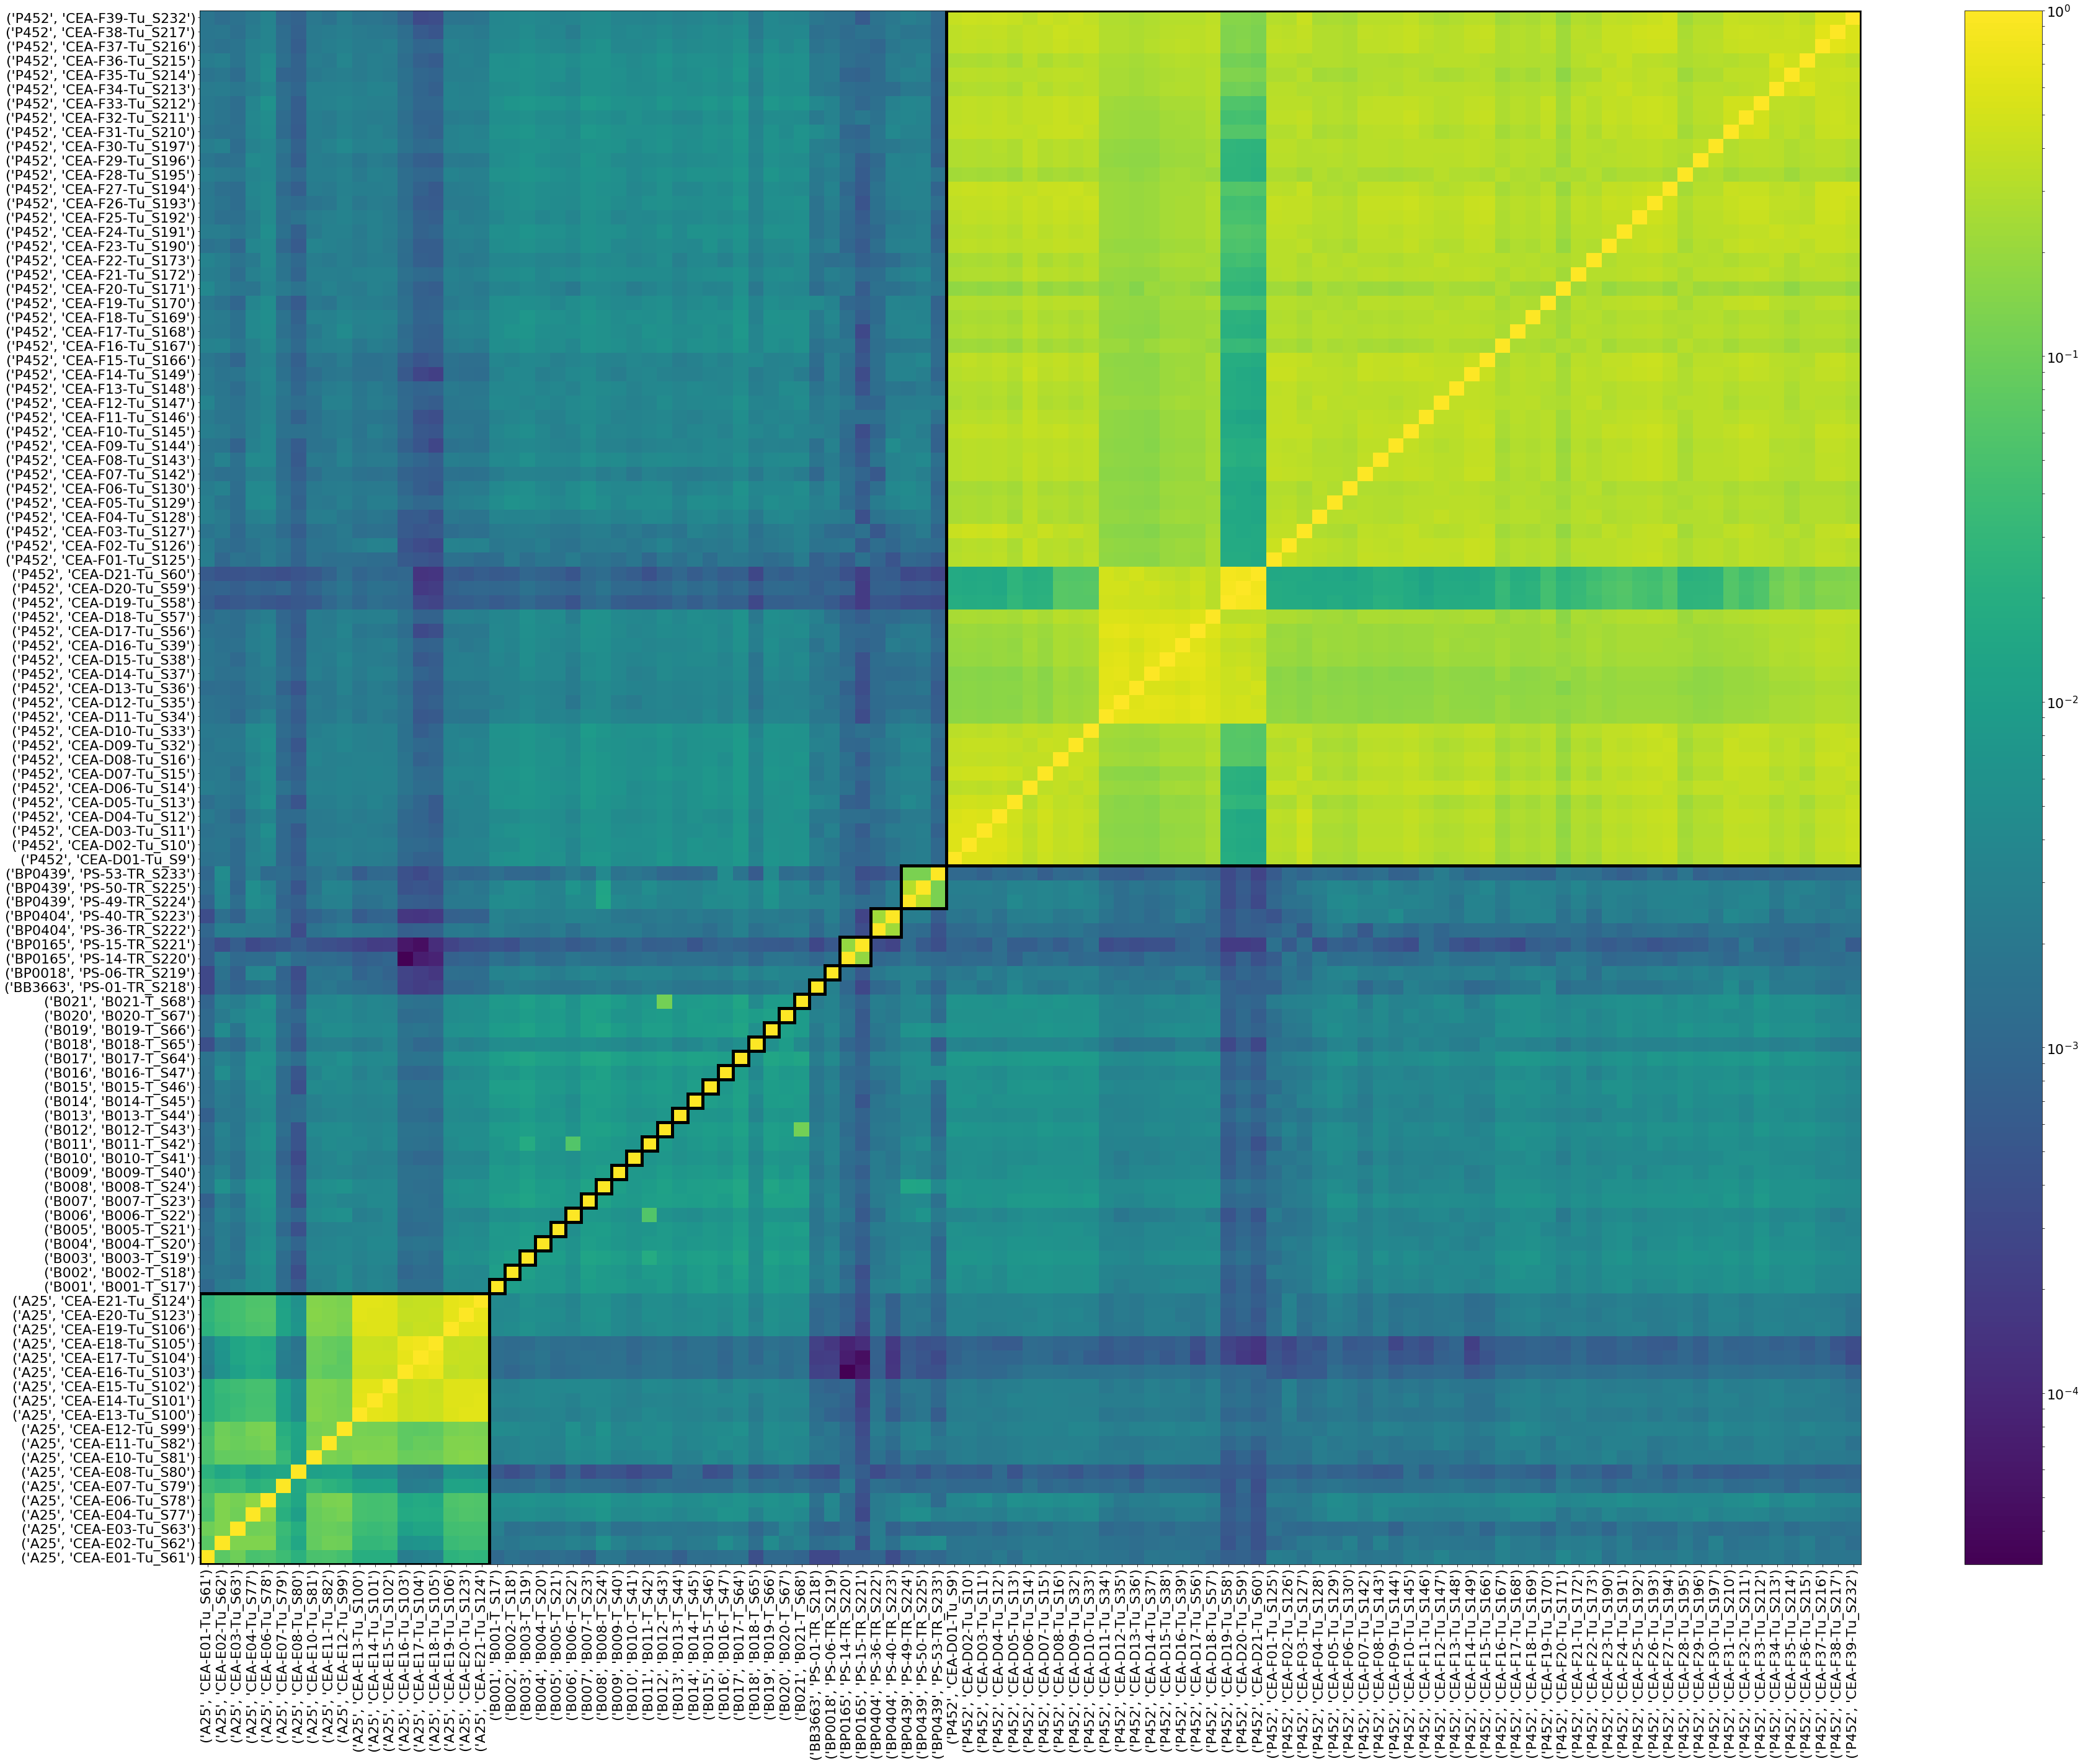

In [15]:
drawHeatmap(sim)

## Highlight anomalies

In [16]:
# get index pairs of same patient (divide same vs not same sample) and list indices for different patients
same_sample = list()
same_patient = list()
diff_patient = list()
for x in sim.index:
    for y in sim.columns:
        if x[0] == y[0]:  # same patient
            if x[1] == y[1]:  # same sample
                same_sample.append((x, y))
            else:        # same patient, but not same sample
                same_patient.append((x, y))
        else:             # not same patient
            diff_patient.append((x,y))                    

In [17]:
# Get values of same patient (but different samples) and values for different patients
values_same_patient = [sim.loc[x][y] for x,y in same_patient]
values_diff_patient = [sim.loc[x][y] for x,y in diff_patient]
mean_diff_patient = np.mean(values_diff_patient)
std_diff_patient = np.std(values_diff_patient)
threshold = mean_diff_patient + 4 * std_diff_patient
print("mean same patient", np.mean(values_same_patient), np.std(values_same_patient))
print("mean diff patient", mean_diff_patient, std_diff_patient)
print("threshold", threshold)

mean same patient 0.27803541860279457 0.12774852803720896
mean diff patient 0.003238617662607454 0.002921308050884395
threshold 0.014923849866145034


{'boxes': [<matplotlib.lines.Line2D at 0x7fae7f5da160>,
 'caps': [<matplotlib.lines.Line2D at 0x7fae7f5dab70>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fae7f5e1828>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fae7f5e1400>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7fae7f5da2b0>,
  <matplotlib.lines.Line2D at 0x7fae7f5e8518>]}

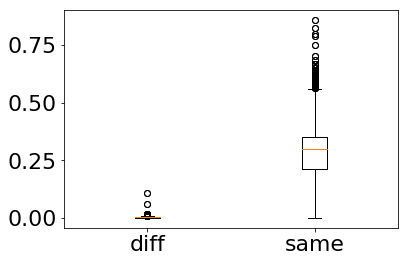

In [18]:
# Boxplot
plt.boxplot([values_diff_patient, values_same_patient], labels=['diff', 'same'])

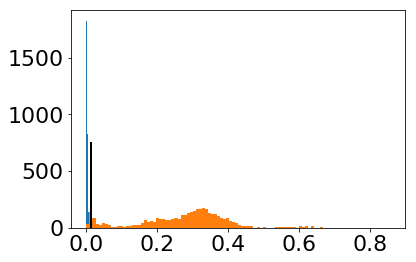

In [19]:
# Histogram
plt.hist(values_diff_patient, bins=100)
plt.hist(values_same_patient, bins=100)
plt.plot([threshold, threshold], [0, 750], 'k-', lw=2)

In [20]:
# Print sample names if similarity is twice the 95% interval
fhOut = open(suspects_list, "w")
check_samples = list()
for i,j in diff_patient:
    if sim.loc[i][j] > threshold:
        print(i, j, sim.loc[i][j])
        print(i, j, sim.loc[i][j], file=fhOut)
        check_samples.append((i,j))
fhOut.close()
print("Wrote", suspects_list, "to disk")

('B003', 'B003-T_S19') ('B011', 'B011-T_S42') 0.0177519108466071
('B006', 'B006-T_S22') ('B011', 'B011-T_S42') 0.06118461552187138
('B008', 'B008-T_S24') ('B017', 'B017-T_S64') 0.0154540162980209
('B011', 'B011-T_S42') ('B003', 'B003-T_S19') 0.0177519108466071
('B011', 'B011-T_S42') ('B006', 'B006-T_S22') 0.06118461552187138
('B012', 'B012-T_S43') ('B021', 'B021-T_S68') 0.10869918099313802
('B017', 'B017-T_S64') ('B008', 'B008-T_S24') 0.0154540162980209
('B021', 'B021-T_S68') ('B012', 'B012-T_S43') 0.10869918099313802
Wrote run29-similarity-TRB_HUMAN.txt to disk


In [21]:
sim2 = sim.copy()
for i, j in check_samples:
    sim2.loc[i][j] = 1

min value: 3.2007169605940966e-05
max value: 1.0
Wrote run29-similarity-TRB_HUMAN-highlighted.pdf to disk


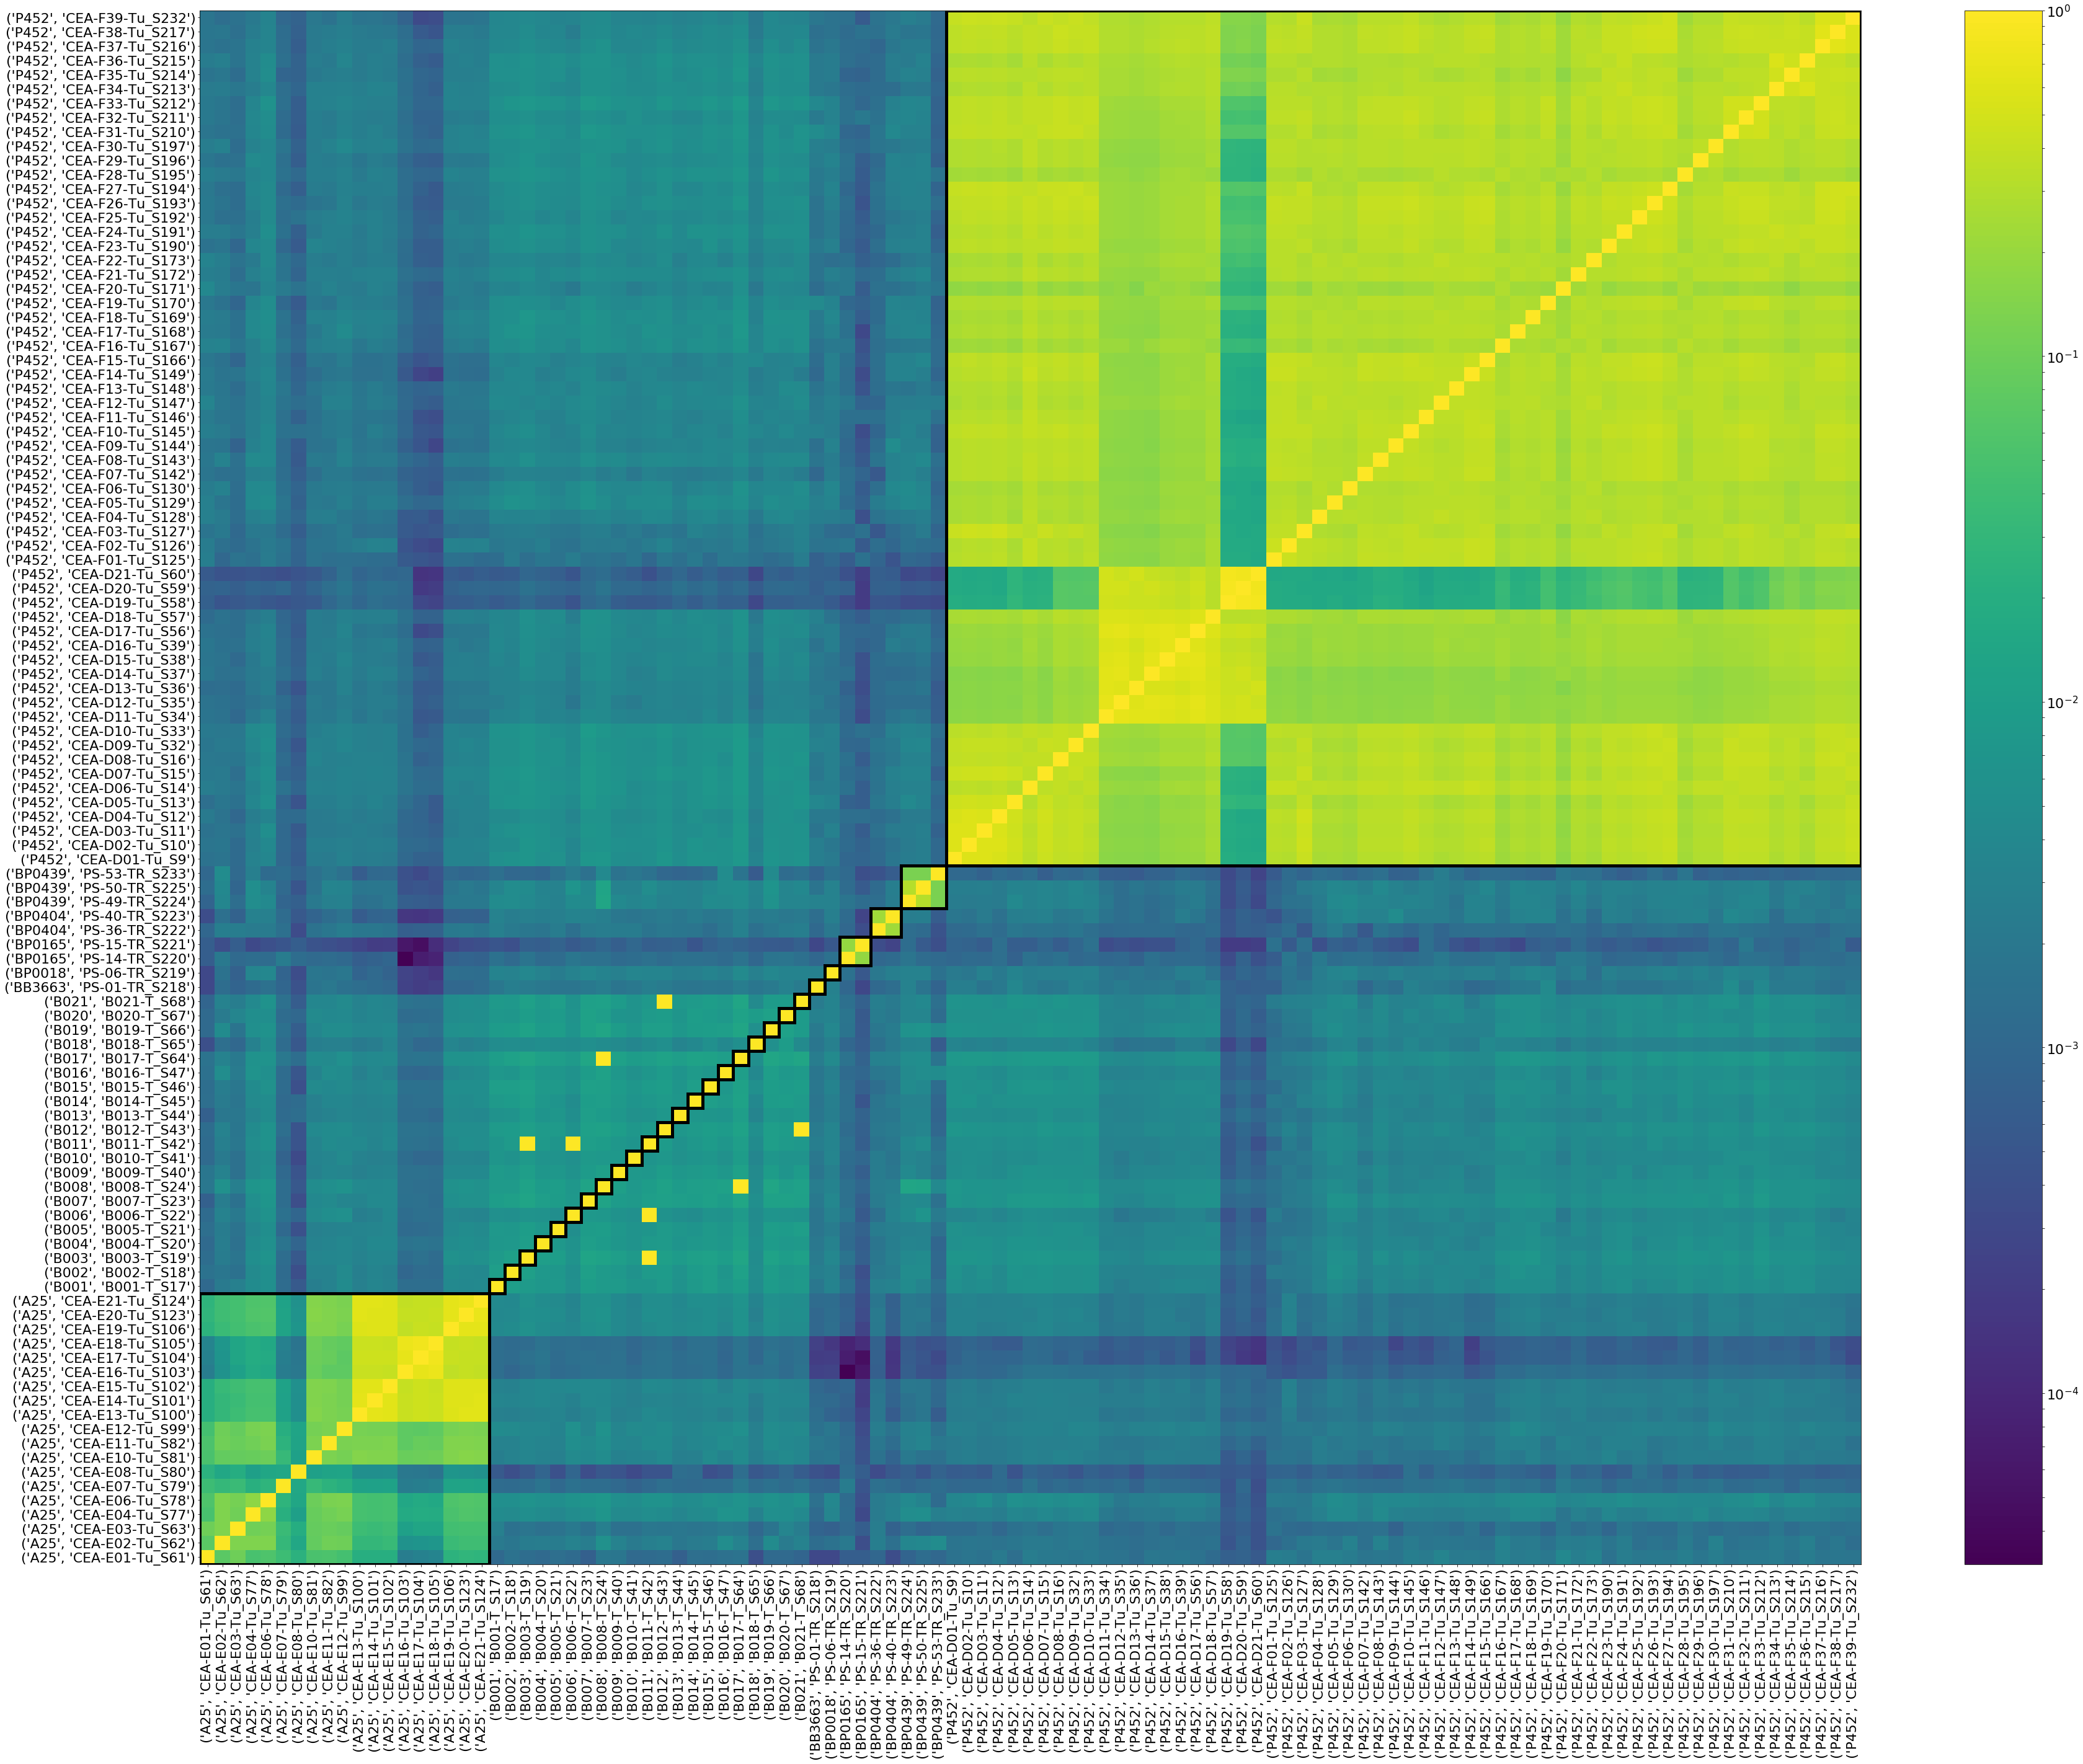

In [22]:
plotfile = plotfile.replace('.pdf', '-highlighted.pdf')
drawHeatmap(sim2)